Face recognition identifies persons on face images or video frames. In a nutshell, a face recognition system extracts features from an input face image and compares them to the features of labeled faces in a database. Comparison is based on a feature similarity metric and the label of the most similar database entry is used to label the input image. If the similarity value is below a certain threshold the input image is labeled as *unknown*. Comparing two face images to determine if they show the same person is known as face verification.

In this project, the Face recognition performance of the model is evaluated on a subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset which can be replaced with any custom dataset, even with images of our family and friends. After an overview of the CNN architecure and how the model can be trained, it is demonstrated how to:

- Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.
- Use the CNN to extract 128-dimensional representations, or *embeddings*, of faces from the aligned input images. In embedding space, Euclidean distance directly corresponds to a measure of face similarity. 
- Compare input embedding vectors to labeled embedding vectors in a database. Here, a support vector machine (SVM), KNN and Random Forest classifier are trained on labeled embedding vectors, in order to carry out the face recognition. Face recognition in this context means using these classifiers to predict the labels i.e. identities of new inputs.

In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

### CNN architecture and training

The CNN architecture used here is a variant of the inception (GoogleNet) architecture. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the *embedding layer* from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in the model.py file and a graphical overview is given in the model.png file.

In [2]:
from model import create_model
nn4_small2 = create_model()

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set.

During training, it is important to select triplets whose positive pairs $(x^a_i, x^p_i)$ and negative pairs $(x^a_i, x^n_i)$ are hard to discriminate i.e. their distance difference in embedding space should be less than margin $\alpha$, otherwise, the network is unable to learn a useful embedding. Therefore, each training iteration should select a new batch of triplets based on the embeddings learned in the previous iteration.

Instead of actually training a model from scratch, we use a pre-trained model as training from scratch is very expensive and requires huge datasets to achieve good generalization performance. For example, the inception model (GoogleNet) uses a dataset of 200M images consisting of about 8M identities. 

In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [4]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [5]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images (42)')

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, I've used Dlib for face detection and OpenCV for image transformation and cropping to produce aligned 96x96 RGB face images. By using the AlignDlib utility from the OpenFace project this is straightforward:

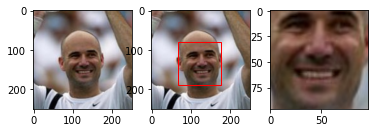

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[25].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [7]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [11]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

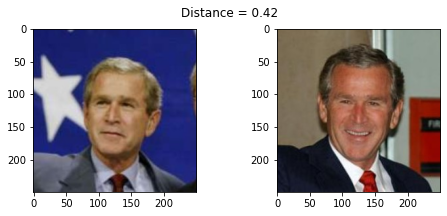

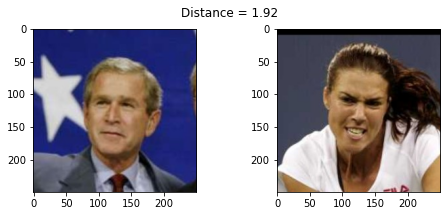

In [12]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(90, 95)
show_pair(90, 190)

As expected, the distance between the two images of the same individual is smaller than the distance between the images of two different individuals (0.42 < 1.92). But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the F1 score as evaluation metric instead of accuracy.

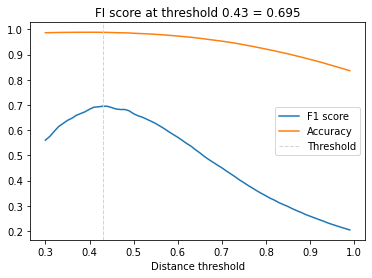

In [13]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)
opt_f1 = f1_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'FI score at threshold {opt_tau:.2f} = {opt_f1:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

The face verification accuracy at $\tau$ = 0.43 is 98.8%. 

### Face recognition

Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label *unknown* otherwise. This procedure can also scale to large databases as it can be easily parallelized. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

A classifier can be trained with the database entries. SVM, KNN, and Random Forest classifiers have been trained, and for training these classifiers we use 50% of the dataset, for evaluation the other 50%.

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()
rf = RandomForestClassifier()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
rf.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_rf = accuracy_score(y_test, rf.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9428571428571428, SVM accuracy = 0.9809523809523809


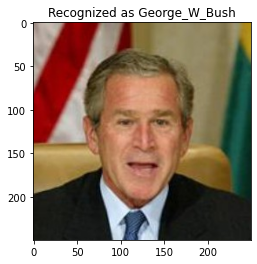

In [15]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 47

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

In [17]:
from sklearn.metrics import classification_report
print("Classification report for KNN")
print(classification_report(y_test, knn.predict(X_test)))

Classification report for KNN
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.00      0.80      0.89         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00        

In [18]:
print("Classification report for SVM")
print(classification_report(y_test, svc.predict(X_test)))

Classification report for SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00        

In [19]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=25, funneled=True, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 2588
dimensionality of images: (154, 154, 3)
number of unique classes (people): 42


In [20]:
def plot_barh_f1_knn(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('F1 Score', fontsize='x-large')
    plt.ylabel('Class', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(0.94, color='green', linewidth=2)
    plt.tight_layout()

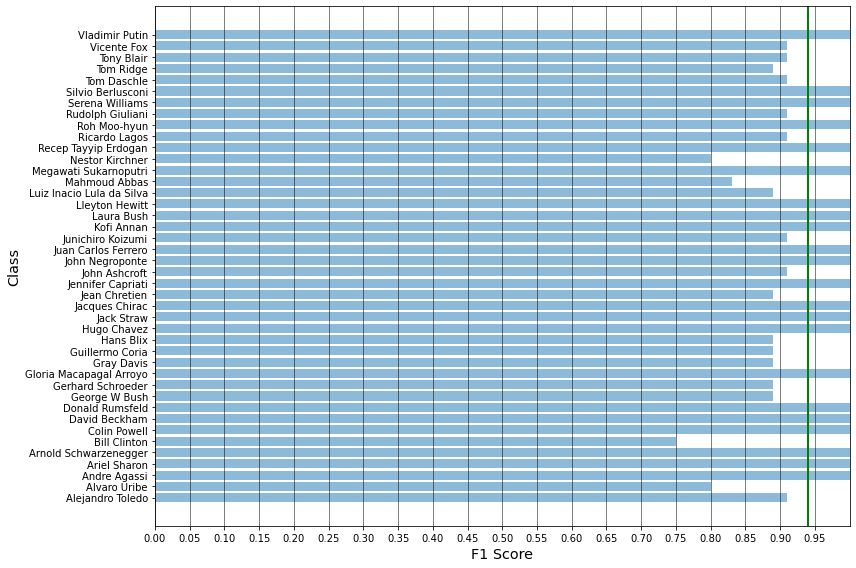

In [21]:
f1_scores_KNN = [0.91, 0.80, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.89, 0.89, 1.0, 0.89, 0.89, 0.89, 1.0, 1.0, 1.0, 0.89, 1.0, 0.91, 1.0, 1.0, 0.91, 1.0, 1.0, 1.0, 0.89, 0.83, 1.0, 0.80, 1.0, 0.91, 1.0, 0.91, 1.0, 1.0, 0.91, 0.89, 0.91, 0.91, 1.0]
plot_barh_f1_knn(target_names, f1_scores_KNN)

In [22]:
def plot_barh_f1_svm(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('F1 Score', fontsize='x-large')
    plt.ylabel('Class', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(0.98, color='green', linewidth=2)
    plt.tight_layout()

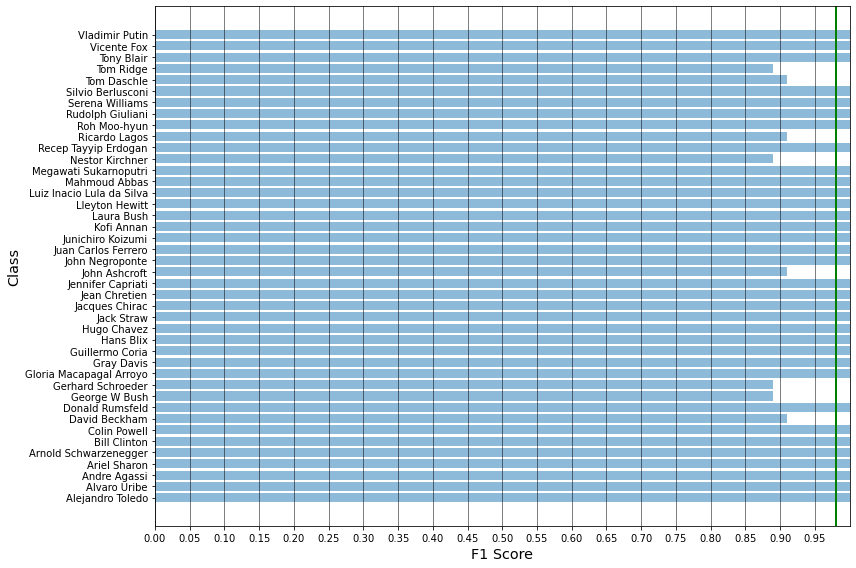

In [23]:
f1_scores_svm = [1,1,1,1,1,1,1,0.91,1,0.89,0.89,1,1,1,1,1,1,1,1,1,0.91,1,1,1,1,1,1,1,1,1,0.89,1,0.91,1,1,1,1,0.91,0.89,1,1,1]
plot_barh_f1_svm(target_names, f1_scores_svm)